This file is a replication of an unpublished masters thesis from SJSU. However, it uses a limited data set, since I created this file to ensure that the pipelines later used in my paper properly work.

Although I am uploading this file now, this file was originally mostly modified June 25-26, and briefly modified on July 21.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip3 install river

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import sklearn.metrics as skm
from sklearn.utils import shuffle

from gensim.models import Word2Vec

from river import forest
from river import metrics
from river import evaluate
from river import stream
from river import neighbors
from river import drift
from river import ensemble
from river import compat
from river import tree

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/23-24/summer 24/malware.csv')

In [ ]:
df = shuffle(df)

# Data Preprocessing (don't run, import df)

import files from google drive into data frames


In [ ]:
df = pd.DataFrame(columns = ['filename', 'text', 'label'])
# winwebsec
for filename in os.listdir('/content/drive/MyDrive/23-24/summer 24/malware2/winwebsec'):
  if filename.endswith('.txt'):
    path = '/content/drive/MyDrive/23-24/summer 24/malware2/winwebsec/' + filename
    with open(path, 'r') as file:
      text = file.read().replace('\n', ' ')
    df.loc[int(len(df.index))]  = [filename, text, 'winwebsec']

# zbot
for filename in os.listdir('/content/drive/MyDrive/23-24/summer 24/malware2/zbot'):
  if filename.endswith('.txt'):
    path = '/content/drive/MyDrive/23-24/summer 24/malware2/zbot/' + filename
    with open(path, 'r') as file:
      text = file.read().replace('\n', ' ')
    df.loc[int(len(df.index))]  = [filename, text, 'zbot']

# zeroaccess
for filename in os.listdir('/content/drive/MyDrive/23-24/summer 24/malware2/zeroaccess'):
  path = '/content/drive/MyDrive/23-24/summer 24/malware2/zeroaccess/' + filename
  if filename.endswith('.txt'):
    with open(path, 'r') as file:
      text = file.read().replace('\n', ' ')
    df.loc[int(len(df.index))]  = [filename, text, 'zeroaccess']

In [ ]:
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

distribution of malware families

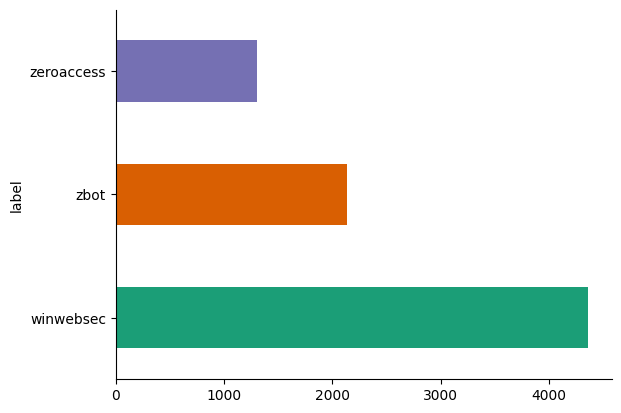

In [ ]:
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

convert text column into opcode columns

In [ ]:
vectorizer = CountVectorizer()
vectorize = vectorizer.fit_transform(df['text'])

opcode_df = pd.DataFrame(vectorize.toarray(), columns = vectorizer.get_feature_names_out())
df = pd.concat([df, opcode_df], axis = 1)

drop filename and text columns

In [ ]:
df.drop('filename', axis = 1, inplace = True)
df.drop('text', axis = 1, inplace = True)

In [ ]:
df.to_csv('malware.csv', index = False)

# Train Models (non-adaptive)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis = 1), df['label'], test_size = 0.2, random_state = 42)

random forest classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

kNN classifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

adaboost classifier

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

svm classifier

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Train Models (Word2Vec)

In [ ]:
df_w2v = pd.read_csv('/content/drive/MyDrive/23-24/summer 24/malware_2vec.csv')

Continuous Bag of Words

In [ ]:
DIMENSIONS = 150
texts = [str(text).split() for text in df_w2v['text']]
w2v = Word2Vec(texts, vector_size = DIMENSIONS)

In [ ]:
keyed_vecs = w2v.wv

In [ ]:
X = []
for sample in df_w2v['text']:
  sum = 0       # sum of all vectors
  count = 0     # number of vectors in the average
  for split in str(sample).split(): # for each token
    try:                    # test to see if token is in keyed vector dictionary
      keyed_vecs[split]
    except KeyError:
      continue
    sum += keyed_vecs[split]
    count += 1
  if count != 0:
    X.append(sum/count)     # add averaged vector to X
  else:
    X.append(np.zeros(DIMENSIONS)) # if no vectors are in dictionary, add a neutral, zero vector

# split data set
X_trainw2v,X_testw2v,y_trainw2v,y_testw2v=train_test_split(X, df_w2v['label'], test_size=0.1, random_state=7)

In [ ]:
w2v_rfc = RandomForestClassifier()
w2v_rfc.fit(X_trainw2v, y_trainw2v)
y_pred_w2v_rfc = w2v_rfc.predict(X_testw2v)

Skip Gram

In [ ]:
w2v_sg = Word2Vec(texts, vector_size = DIMENSIONS, sg = 1)

In [ ]:
keyed_vecs_sg = w2v_sg.wv

In [ ]:
X_sg = []
for sample in df_w2v['text']:
  sum = 0       # sum of all vectors
  count = 0     # number of vectors in the average
  for split in str(sample).split(): # for each token
    try:                    # test to see if token is in keyed vector dictionary
      keyed_vecs_sg[split]
    except KeyError:
      continue
    sum += keyed_vecs_sg[split]
    count += 1
  if count != 0:
    X_sg.append(sum/count)     # add averaged vector to X
  else:
    X_sg.append(np.zeros(DIMENSIONS)) # if no vectors are in dictionary, add a neutral, zero vector

# split data set
X_trainw2v_sg,X_testw2v_sg,y_trainw2v_sg,y_testw2v_sg=train_test_split(X_sg, df_w2v['label'], test_size=0.1, random_state=7)

In [ ]:
w2v_sg_rfc = RandomForestClassifier()
w2v_sg_rfc.fit(X_trainw2v_sg, y_trainw2v_sg)
y_pred_w2v_sg_rfc = w2v_sg_rfc.predict(X_testw2v_sg)

# Evaluate

In [ ]:
evaluation_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Confusion Matrix'])

In [ ]:
def evaluate(df, name, y_pred, y_test):
  acc = skm.accuracy_score(y_test, y_pred)
  #prec = str(skm.precision_score(y_test, y_pred))
  #recall = str(skm.recall_score(y_test, y_pred))
  #f1 = str(skm.f1_score(y_test, y_pred))
  conf = str(skm.confusion_matrix(y_test, y_pred))
  df.loc[int(len(df.index))] = [name, acc, conf]
  return df

In [ ]:
evaluate(evaluation_df, "rfc", y_pred_rfc, y_test)

In [ ]:
evaluate(evaluation_df, "knn", y_pred_knn, y_test)

In [ ]:
evaluate(evaluation_df, "ada", y_pred_ada, y_test)

In [ ]:
evaluate(evaluation_df, "svm", y_pred_svm, y_test)

In [ ]:
evaluate(evaluation_df, "w2v rfc", y_pred_w2v_rfc, y_testw2v)

In [ ]:
evaluate(evaluation_df, "w2v sg rfc", y_pred_w2v_sg_rfc, y_testw2v_sg)

,Model,Accuracy,Confusion Matrix
0,rfc,0.998078,[[860 0 0]\n [ 1 424 0]\n [ 0 2 274]]
1,knn,0.997438,[[860 0 0]\n [ 1 423 1]\n [ 1 1 274]]
2,ada,0.960922,[[806 54 0]\n [ 4 421 0]\n [ 0 3 273]]
3,svm,0.905189,[[859 0 1]\n [142 280 3]\n [ 0 2 274]]
4,w2v rfc,0.997439,[[465 1 0]\n [ 0 196 1]\n [ 0 0 118]]
5,w2v sg rfc,0.997439,[[465 1 0]\n [ 0 196 1]\n [ 0 0 118]]


# Train Models (adaptive)

Adaptive Random Forest: Balanced Accuracy = 95.93%

In [ ]:
arfc = forest.ARFClassifier(seed=8, leaf_prediction="mc")
st = stream.iter_pandas(df.drop('label', axis = 1), df['label'])
evaluate.progressive_val_score(st, arfc, metric = metrics.BalancedAccuracy(), print_every = 1000, delay = 1)

[1,000] BalancedAccuracy: 83.62%
[2,000] BalancedAccuracy: 88.29%
[3,000] BalancedAccuracy: 91.54%
[4,000] BalancedAccuracy: 93.10%
[5,000] BalancedAccuracy: 94.15%
[6,000] BalancedAccuracy: 94.95%
[7,000] BalancedAccuracy: 95.46%
[7,801] BalancedAccuracy: 95.83%


BalancedAccuracy: 95.83%

Adaptive KNN Classifier: Balanced Accuracy = 90.08%

In [ ]:
knnadwin = neighbors.KNNClassifier()
st = stream.iter_pandas(df.drop('label', axis = 1), df['label'])
evaluate.progressive_val_score(st, knnadwin, metric = metrics.BalancedAccuracy(), print_every = 1000, delay = 1)

[1,000] BalancedAccuracy: 96.40%
[2,000] BalancedAccuracy: 93.19%
[3,000] BalancedAccuracy: 91.77%
[4,000] BalancedAccuracy: 91.36%
[5,000] BalancedAccuracy: 91.02%
[6,000] BalancedAccuracy: 90.81%
[7,000] BalancedAccuracy: 90.17%
[7,801] BalancedAccuracy: 90.08%


BalancedAccuracy: 90.08%

In [ ]:
# online boosting classifier
ob = ensemble.AdaBoostClassifier(tree.HoeffdingTreeClassifier())
st = stream.iter_pandas(df.drop('label', axis = 1), df['label'])
evaluate.progressive_val_score(st, ob, metric = metrics.BalancedAccuracy(), print_every = 500)

[500] BalancedAccuracy: 87.98%
[1,000] BalancedAccuracy: 85.95%
[1,500] BalancedAccuracy: 85.07%
[2,000] BalancedAccuracy: 84.56%
[2,500] BalancedAccuracy: 84.31%
[3,000] BalancedAccuracy: 83.14%
[3,500] BalancedAccuracy: 81.83%
[4,000] BalancedAccuracy: 81.08%
[4,500] BalancedAccuracy: 80.80%
[5,000] BalancedAccuracy: 81.27%
[5,500] BalancedAccuracy: 81.48%
[6,000] BalancedAccuracy: 81.53%
[6,500] BalancedAccuracy: 81.62%
[7,000] BalancedAccuracy: 82.24%
[7,500] BalancedAccuracy: 82.78%
[7,801] BalancedAccuracy: 83.36%


BalancedAccuracy: 83.36%

In [ ]:
ob2 = ensemble.ADWINBoostingClassifier(tree.HoeffdingTreeClassifier())
st = stream.iter_pandas(df.drop('label', axis = 1), df['label'])
evaluate.progressive_val_score(st, ob2, metric = metrics.BalancedAccuracy(), print_every = 500)

[500] BalancedAccuracy: 87.41%
[1,000] BalancedAccuracy: 85.94%
[1,500] BalancedAccuracy: 85.17%
[2,000] BalancedAccuracy: 85.02%
[2,500] BalancedAccuracy: 84.80%
[3,000] BalancedAccuracy: 84.51%
[3,500] BalancedAccuracy: 84.15%
[4,000] BalancedAccuracy: 83.78%
[4,500] BalancedAccuracy: 84.08%
[5,000] BalancedAccuracy: 84.05%
[5,500] BalancedAccuracy: 84.25%
[6,000] BalancedAccuracy: 84.14%
[6,500] BalancedAccuracy: 84.13%
[7,000] BalancedAccuracy: 84.20%
[7,500] BalancedAccuracy: 83.97%
[7,801] BalancedAccuracy: 83.85%


BalancedAccuracy: 83.85%

# Evaluate (+ adaptive)

In [ ]:
evaluation_df.loc[int(len(evaluation_df.index))] = ['adaptive rfc', .9583, '']
evaluation_df.loc[int(len(evaluation_df.index))] = ['adaptive knn', .9008, '']
evaluation_df.loc[int(len(evaluation_df.index))] = ['online boosting', .8385, '']

# Final Evaluations

In [ ]:
evaluation_df.sort_values(by = 'Accuracy', ascending = True, inplace = True)
fig = px.bar(evaluation_df, x = 'Model', y = 'Accuracy', color = 'Model')
fig.show()